# Overview

This notebook focuses on:

1. Retrieving relevant context from a research about RAG https://arxiv.org/pdf/2312.10997.
2. Formatting prompts for Large Language Models (LLMs) using the retrieved context.
3. Generating high-quality responses without fabricating unsupported details.



# 1. Read File and Text Processing

## Import Dependencies

In [121]:
# Google Colab installs
import os

if "COLAB_GPU" in os.environ:
    !pip install -U torch
    !pip install --upgrade --force-reinstall PyMuPDF # for reading PDFs with Python
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    !pip install tqdm

  Using cached PyMuPDF-1.24.14-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.4 kB)
Using cached PyMuPDF-1.24.14-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (19.8 MB)
  Attempting uninstall: PyMuPDF
    Found existing installation: PyMuPDF 1.24.14
    Uninstalling PyMuPDF-1.24.14:
      Successfully uninstalled PyMuPDF-1.24.14


In [122]:
import pandas as pd
import tqdm
import fitz
from spacy.lang.en import English
from sentence_transformers import SentenceTransformer
import requests
import torch

Define Torch's Device

In [123]:
if "COLAB_GPU" in os.environ:
   device = 'cuda'
elif torch.backends.mps.is_available():
   device = 'mps' # For MacOS
else:
   device = 'cpu'

## Read the PDF File

In [124]:
pdf_path = 'RAG for LLM.pdf'
url = 'https://arxiv.org/pdf/2312.10997'

if not os.path.exists(pdf_path):
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open a file in binary write mode and save the content to it
        with open(pdf_path, "wb") as file:
            file.write(response.content)
        print(f"The file has been downloaded and saved as {pdf_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")


File RAG for LLM.pdf exists.


In [125]:
doc = fitz.open(pdf_path)

pdf_file = []
for page_number, page in enumerate(doc):  # iterate the document pages
    text = page.get_text()  # get plain text encoded as UTF-8
    text = text.replace("\n", " ").strip()
    pdf_file.append({"page_number": page_number,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text) / 4,
                            "text": text})
len(pdf_file)

21

In [126]:
df = pd.DataFrame(pdf_file)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,5451,739,28,1362.75,1 Retrieval-Augmented Generation for Large Lan...
1,1,3082,450,32,770.50,2 Fig. 1. Technology tree of RAG research. The...
2,2,3950,575,41,987.50,3 Fig. 2. A representative instance of the RAG...
3,3,3574,492,30,893.50,4 Fig. 3. Comparison between the three paradig...
4,4,6362,887,42,1590.50,5 aligns the text more closely with data distr...


## Text Processing

### Sentencizer

In [127]:
nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")
# Test
list(nlp("First sentences. Second sentence.").sents)

[First sentences., Second sentence.]

In [128]:
df['sentences_list'] = df['text'].apply(lambda text: list(nlp(text).sents))
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences_list
0,0,5451,739,28,1362.75,1 Retrieval-Augmented Generation for Large Lan...,"[(1, Retrieval, -, Augmented, Generation, for,..."
1,1,3082,450,32,770.50,2 Fig. 1. Technology tree of RAG research. The...,"[(2, Fig, .), (1, .), (Technology, tree, of, R..."
2,2,3950,575,41,987.50,3 Fig. 2. A representative instance of the RAG...,"[(3, Fig, .), (2, .), (A, representative, inst..."
3,3,3574,492,30,893.50,4 Fig. 3. Comparison between the three paradig...,"[(4, Fig, .), (3, .), (Comparison, between, th..."
4,4,6362,887,42,1590.50,5 aligns the text more closely with data distr...,"[(5, aligns, the, text, more, closely, with, d..."


From Page 16 onward are about the references which don't have much important information, so I decided to drop them.

In [129]:
df.drop([16, 17, 18, 19, 20], inplace=True)

Since I plan to use `all-mpnet-base-v2` model which has a capacity of 384 tokens to embed the text.

So, the text has to be splitted into chunks to make sure that they are not exceed the model's capacity.

### Chunk sentences together

In [130]:
# Create a split list function
# e.g. [7] --> [5, 2]
def split_list(input_list: list, slice_size: int = 5):
    temp = []
    # Convert dtype = spacy.tokens.span.Span to String
    for sentence in input_list:
        temp.append(sentence.text)
    input_list = temp
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

In [131]:
df['splitted_list'] = df['sentences_list'].apply(split_list)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences_list,splitted_list
0,0,5451,739,28,1362.75,1 Retrieval-Augmented Generation for Large Lan...,"[(1, Retrieval, -, Augmented, Generation, for,...",[[1 Retrieval-Augmented Generation for Large L...
1,1,3082,450,32,770.50,2 Fig. 1. Technology tree of RAG research. The...,"[(2, Fig, .), (1, .), (Technology, tree, of, R...","[[2 Fig., 1., Technology tree of RAG research...."
2,2,3950,575,41,987.50,3 Fig. 2. A representative instance of the RAG...,"[(3, Fig, .), (2, .), (A, representative, inst...","[[3 Fig., 2., A representative instance of the..."
3,3,3574,492,30,893.50,4 Fig. 3. Comparison between the three paradig...,"[(4, Fig, .), (3, .), (Comparison, between, th...","[[4 Fig., 3., Comparison between the three par..."
4,4,6362,887,42,1590.50,5 aligns the text more closely with data distr...,"[(5, aligns, the, text, more, closely, with, d...",[[5 aligns the text more closely with data dis...


### Create new DataFrame that contains only chunks of text

In [132]:
sentences_df = df.explode('splitted_list')
sentences_df['splitted_list'] = sentences_df['splitted_list'].apply(lambda x: "".join(x))
sentences_df['token_count'] = sentences_df['splitted_list'].apply(lambda x: len(x) / 4)
sentences_df.rename(columns={'page_number': 'page', 'splitted_list': 'sentences'}, inplace=True)
sentences_df = sentences_df[['page', 'token_count', 'sentences']]
sentences_df.head()


,page,token_count,sentences
0,0,303.25,1 Retrieval-Augmented Generation for Large Lan...
0,0,243.25,It meticulously scrutinizes the tripartite fou...
0,0,212.50,"To overcome challenges, Retrieval-Augmented Ge..."
0,0,235.25,"Initially, RAG’s inception coincided with the ..."
0,0,218.50,This survey endeavors to fill this gap by mapp...


## Embedding

In [134]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)


sentences_df['embedding'] = sentences_df['sentences'].apply(lambda sentences: embedding_model.encode(sentences))
sentences_df.head()

,page,token_count,sentences,embedding
0,0,303.25,1 Retrieval-Augmented Generation for Large Lan...,"[0.051494826, 0.048605476, -0.040616732, 0.040..."
0,0,243.25,It meticulously scrutinizes the tripartite fou...,"[0.078784674, 0.02718093, -0.0130607085, 0.013..."
0,0,212.50,"To overcome challenges, Retrieval-Augmented Ge...","[0.061909616, -0.03423412, -0.010302416, 0.023..."
0,0,235.25,"Initially, RAG’s inception coincided with the ...","[0.03596034, 0.011139151, -0.017413778, 0.0121..."
0,0,218.50,This survey endeavors to fill this gap by mapp...,"[0.031225106, 0.018977925, -0.0044133575, -0.0..."


# 2. RAG Implementation

In [135]:
import torch
import numpy as np
from sentence_transformers import util, SentenceTransformer

# Convert embeddings to torch tensor
embeddings = torch.tensor(np.array(sentences_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([106, 768])

### Sematic Search

Steps:
1. Define a query string
2. Turn the query string into an embedding with same model.
3. Perform a `dot product` or `cosine similarity` to get similarity scores.
4. Retrieve the highest score from Step 3

This is the part where we try to search for:

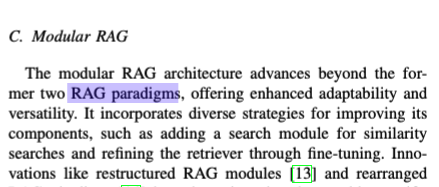

In [136]:
# 1. Define a query string
query = "RAG paradigms"

# 2. Turn the query string into an embedding with same model.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Perform a `dot product` or `cosine similarity` to get similarity scores.
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4. Retrieve the highest score from Step 3
dot_product_results = torch.topk(dot_scores, k=5) # k=5 means top 5
dot_product_results

torch.return_types.topk(
values=tensor([0.6247, 0.5097, 0.4903, 0.4871, 0.4640], device='cuda:0'),
indices=tensor([12, 21, 18, 22, 11], device='cuda:0'))

In [137]:
for score, idx in zip(dot_product_results[0], dot_product_results[1]):
    print(f"Score = {score:.3f}\n Sentence = {sentences_df.iloc[idx.item()]['sentences']}\n")

Score = 0.625
 Sentence = A. Naive RAG The Naive RAG research paradigm represents the earli- est methodology, which gained prominence shortly after the

Score = 0.510
 Sentence = 4 Fig.3.Comparison between the three paradigms of RAG. (Left) Naive RAG mainly consists of three parts: indexing, retrieval and generation. (Middle) Advanced RAG proposes multiple optimization strategies around pre-retrieval and post-retrieval, with a process similar to the Naive RAG, still following a chain-like structure. (

Score = 0.490
 Sentence = However, Naive RAG encounters notable drawbacks: Retrieval Challenges.The retrieval phase often struggles with precision and recall, leading to the selection of misaligned or irrelevant chunks, and the missing of crucial information.Generation Difficulties.In generating responses, the model may face the issue of hallucination, where it produces con- tent not supported by the retrieved context.This phase can also suffer from irrelevance, toxicity, or bias in the 

## Functionizing the semantic search

In [138]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                top: int=5):
    # Turn the query string into an embedding
    query_embedding = model.encode(query, convert_to_tensor=True)
    # Perform a `dot product` to get similarity scores.
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    # Retrieve the highest score
    scores, indices = torch.topk(input=dot_scores, k=top)

    return scores, indices


# 3. Load a Local LLM

Based on the website below, it requires 8 GB minimum VRAM to use Gemma 2B and 24 GB for Gemma 7B model.

**Ref:** https://github.com/google-deepmind/gemma


In [139]:
if torch.cuda.is_available():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"My GPU memory: {gpu_memory_gb} GB")

My GPU memory: 40 GB


### Get Hugging Face's token

In [140]:
# Run on Google Colab
if "COLAB_GPU" in os.environ:
    from google.colab import userdata
    hf_token = userdata.get('HUGGINGFACE_TOKEN')
# Run on local
else:
    from dotenv import load_dotenv
    load_dotenv(override=True)
    hf_token = os.getenv('HUGGINGFACE_TOKEN')

In [141]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig

# 1. Create quantization config for smaller model loading
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# 2. Define Model ID
model_id = "google/gemma-2b-it"

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          token=hf_token)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config,
                                                 device_map='auto',
                                                 token=hf_token,
                                                 attn_implementation="flash_attention_2")

llm_model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm):

### Text Generation using local LLM

In [142]:
input_text = "What is Retrieval Augmented Generation (RAG) ?"

# Create chat template
template = [
    {"role": "user",
     "content": input_text}
]

# Create Prompt
prompt = tokenizer.apply_chat_template(conversation=template,
                                       tokenize=False,
                                       add_generation_prompt=True,
                                       chat_template=input_text
                                       )

# Tokenize the input text
input_ids = tokenizer(prompt, return_tensors="pt").to(device)

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)

print(tokenizer.decode(outputs[0]))

<bos>What is Retrieval Augmented Generation (RAG) ?

Retrieval Augmented Generation (RAG) is a machine learning technique that combines the strengths of retrieval and generation models to achieve state-of-the-art performance on various tasks.

**Here's how it works:**

1. **Retrieval:** A pre-trained model is used to retrieve relevant information from a large dataset. This information can be text, code, images, or other types of data.
2. **Generation:** The retrieved information is then used as a prompt to generate new content, such as text, code, images, or other types of data.

**Benefits of RAG:**

* **Improved performance:** RAG can achieve state-of-the-art performance on various tasks, including text generation, code generation, and image generation.
* **Robustness:** RAG is robust to noise and variations in the input data.
* **Interpretability:** The generated content can be explained by the pre-trained retrieval model.

**Applications of RAG:**

* **Natural language processing (

### Format the Prompt to ask LLM

In [143]:
def prompt_formatter(query: str, context_items: list) -> str:

    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item for item in context_items])

    # Create a base prompt with contexts from RAG
    base_prompt = """Your task is to act as a knowledgeable assistant that answers queries based on the provided context.
    Below, you will find a query followed by relevant excerpts retrieved from a knowledge base.
    Use the information from these excerpts to construct a clear, concise, and accurate response. Do not fabricate information;
    if the context lacks the required details to fully answer the query, indicate that the answer is incomplete and explain the limitations based on the available context.
    The response should be professional and adhere to the source's details.\n

    Example Structure
    Query: {query}

    Context:

    {context}

    Your Response:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=template,
                                       tokenize=False,
                                       add_generation_prompt=True,
                                       chat_template=base_prompt
                                       )
    return prompt

In [148]:
query = 'RAG paradigm'
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [sentences_df.iloc[i.item()]['sentences'] for i in indices]

# Get the Prompt
print(prompt_formatter(query, context_items))

Query: RAG paradigm
Your task is to act as a knowledgeable assistant that answers queries based on the provided context. 
    Below, you will find a query followed by relevant excerpts retrieved from a knowledge base. 
    Use the information from these excerpts to construct a clear, concise, and accurate response. Do not fabricate information; 
    if the context lacks the required details to fully answer the query, indicate that the answer is incomplete and explain the limitations based on the available context. 
    The response should be professional and adhere to the source's details.

    
    Example Structure
    Query: RAG paradigm
    
    Context:
    
    - A. Naive RAG The Naive RAG research paradigm represents the earli- est methodology, which gained prominence shortly after the
- However, Naive RAG encounters notable drawbacks: Retrieval Challenges.The retrieval phase often struggles with precision and recall, leading to the selection of misaligned or irrelevant chunks, 

### Create Chat Function

In [146]:
def chat(query, temperature=0.7, max_new_tokens=256):

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [sentences_df.iloc[i.item()]['sentences'] for i in indices]

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Replace unnecessary help messages
    output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    return output_text, context_items

# Final Result

In [147]:
query = "What are the steps involved in the retrieval process as described for Naive RAG?"
output_text, context_items = chat(query)
print(f"Response:\n{output_text}\n\n Contexts:\n{context_items}")

Response:


The retrieval process in Naive RAG consists of three main stages: indexing, retrieval, and generation. The details of each stage are as follows:

- Indexing involves optimizing the indexing structure and the original query to enhance the retrieval process.
- Retrieval involves searching for relevant chunks within the indexed corpus based on the query using a chain-like structure.
- Generation involves generating new content based on the retrieved chunks.

 Contexts:
['11 Fig.5.In addition to the most common once retrieval, RAG also includes three types of retrieval augmentation processes. (left) Iterative retrieval involves alternating between retrieval and generation, allowing for richer and more targeted context from the knowledge base at each step. (Middle) Recursive retrieval involves gradually refining the user query and breaking down the problem into sub-problems, then continuously solving complex problems through retrieval and generation. (', 'Right) Modular RAG inhe

### Save LLM's responses to CSV File

In [149]:
query_list = ['What are the steps involved in the retrieval process as described for Naive RAG?',
              'What are the three main paradigms of RAG mentioned in the document, and how do they differ?',
              'What are the modular components introduced in Modular RAG, and how do they enhance system flexibility?',
              'What are the anticipated research trends for handling super-long contexts in RAG systems?',
              'How can RAG systems be tailored for domain-specific tasks, such as medical or legal question answering?']

final_result = []

for question in query_list:
    chat_log = {}
    output_text, context_items = chat(question)
    chat_log['query'] = question
    chat_log['relevant_contexts'] = context_items
    chat_log['llm_response'] = output_text
    final_result.append(chat_log)

final_result_df = pd.DataFrame(final_result)
final_result_df.to_csv('final_result.csv')